# Simulate an inverted pendulum (CartPole) system

References: 
- https://www.youtube.com/watch?v=Fo7kuUAHj3s (EoM for the inverted Pendulum, "Good Vibrations with Freeball").
- https://underactuated.mit.edu/acrobot.html#cart_pole


![](figures/cartpole.svg)

In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()
IJulia.clear_output();

 Interrupted: Exiting precompilation...


In [ ]:
using Printf
using Plots
default(label="", grid=false, margin=10Plots.pt)

In [ ]:
function polar2cart(z)
    "Map centers of masses to Cartesian space"

    # Position of the pole endpoint
    xp = z[2] + l*sin(z[1])
    yp = -l*cos(z[1])
    
    # Position of the cart
    xc = z[2]
    yc = 0.0
    
    return (xp,yp), (xc,yc)
end

## Manual simulation

!TODO

Using Lagrangian mechanics, we obtain the following equations of motion:

$$\begin{align} 
- \\
-
\end{align}$$

We'd like to isolate the second-order derivates on one side:

$$\begin{align} 
- \\
-
\end{align}$$

We can formulate the left-hand side as a matrix-vector product:

$$\begin{align} 
\underbrace{\begin{bmatrix} J_a & J_x \cos(\theta_1 - \theta_2) \\ J_x \cos(\theta_1 - \theta_2) & J_b \end{bmatrix}}_{M(\theta_1, \theta_2)} \begin{bmatrix} \ddot{\theta}_1 \\ \ddot{\theta}_2 \end{bmatrix} = \begin{bmatrix} - J_x \sin(\theta_1 - \theta_2)\dot{\theta}_2^2 - \mu_1 \sin \theta_1 + K_t (\theta_2 - \theta_1) \\
 J_x \sin(\theta_1 - \theta_2)\dot{\theta}_1^2 - \mu_2 \sin \theta_2 + K_t (\theta_2 - \theta_1) \end{bmatrix}
\end{align}$$

and then move the mass matrix to the right-hand side:

$$\begin{align} 
\begin{bmatrix} \ddot{\theta}_1 \\ \ddot{\theta}_2 \end{bmatrix} = M(\theta_1, \theta_2)^{-1} \begin{bmatrix} - J_x \sin(\theta_1 - \theta_2)\dot{\theta}_2^2 - \mu_1 \sin \theta_1 + K_t (\theta_2 - \theta_1) \\
 J_x \sin(\theta_1 - \theta_2)\dot{\theta}_1^2 - \mu_2 \sin \theta_2 + K_t (\theta_2 - \theta_1) \end{bmatrix}
\end{align}$$

The inverse mass matrix can be derived manually:

$$\begin{align}
M^{-1} = 
\end{align}$$


Now, we can use variable substitution, 

$$\begin{align}
z = \begin{bmatrix} \theta & x & \dot{\theta} & \dot{x} \end{bmatrix}^{\top}
\end{align} \, ,$$

to transform this into a first-order system:

$$\begin{align} 
\dot{z} = \begin{bmatrix} z_3 \\ z_4 \\ M(z_1,z_2)^{-1} \begin{bmatrix} - J_x \sin(\theta_1 - \theta_2)\dot{\theta}_2^2 - \mu_1 \sin \theta_1 + K_t (\theta_2 - \theta_1) \\
 J_x \sin(\theta_1 - \theta_2)\dot{\theta}_1^2 - \mu_2 \sin \theta_2 + K_t (\theta_2 - \theta_1) \end{bmatrix} \end{bmatrix}
\end{align}$$

### Discretization

I'll be using a 4-order Runge-Kutta method to obtain a numerical solution.

In [4]:
# Define time scales
tspan = (0.,30.)
dt = 0.05
time = tspan[1]:dt:tspan[end]
T = length(time)

601

In [5]:
# System parameters
mc = 1   # kg
mp = 1   # kg
l  = 1   # m
const G = 9.81 # N or kg*m / s^2

9.81

In [6]:
# Control
function Fx(t)
    if 1 < t <= 15
        return 1
    else
        return 0
    end
end

Fx (generic function with 1 method)

In [7]:
function dzdt(z,t)
   "Derivative function"
    
    # Compute control
    u = Fx(t)
    
    # Equations of motion
    ddθ = 1/(l*mc+l*mp*sin(z[1])^2) * (-u*cos(z[1]) - mp*l*z[3]^2*cos(z[1])*sin(z[1]) - (mc+mp)*G*sin(z[1]))
    ddx = 1/(mc+mp*sin(z[1])^2) * (u + mp*sin(z[1])*(l*z[3]^2 + G*cos(z[1])))
    
    # Equations of motion
    return [z[3]; z[4]; ddθ; ddx]
end

dzdt (generic function with 1 method)

In [8]:
function RK4(z,t,dt)

    K1 = dzdt(z,t)
    K2 = dzdt(z + K1*dt/2, t+dt/2)
    K3 = dzdt(z + K2*dt/2, t+dt/2)
    K4 = dzdt(z + K3*dt, t+dt)

    return dt*1/6*(K1 + 2*K2 + 2*K3 + K4)
end

RK4 (generic function with 1 method)

In [9]:
# Allocate
z_ = zeros(4,T)

# Initial state
z_0 = [π, 0, 0, 0]

# Define previous timepoint
z_tmin1 = z_0

# Time-stepping
for (ii,t) in enumerate(time)

    # Update state
    z_[:,ii] = z_tmin1 + RK4(z_tmin1,t, dt)

    # Update previous variables
    z_tmin1 = z_[:,ii]

end

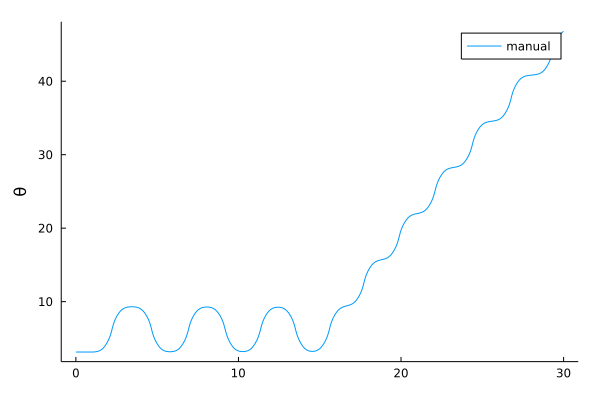

In [10]:
plot(time, z_[1,:], label="manual", ylabel="θ")

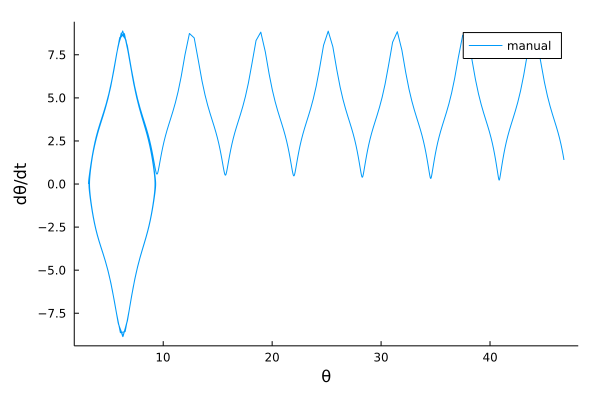

In [11]:
plot(z_[1,:], z_[3,:], label="manual", xlabel="θ", ylabel="dθ/dt")

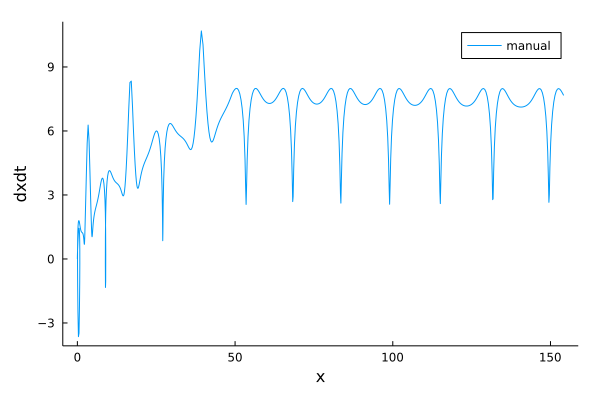

In [12]:
plot(z_[2,:], z_[4,:], label="manual", xlabel="x", ylabel="dxdt")

In [ ]:
anim = @animate for (i,t) in enumerate(time)
   
    # Cartesian positions of centers of mass
    com1, com2 = polar2cart(z_[:,i])
    
    # Compute control
    u = Fx.(time[1:i])
    u = cat(u..., dims=2)
    
    # Plot line
    p1 = plot([com1; com2], linewidth=10, alpha=0.5, label=@sprintf("t = %.1f", t), xlims=[-2,2], ylims=[-2,2], grid=true, color="black")
    
    # Point masses
    scatter!([com1[1]], [com1[2]], color="red")
    scatter!([com2[1]], [com2[2]], color="blue")
    
    p2 = plot(time[1:i], u[1,:], color="red", xlims=[time[1], time[end]], ylims=[-1,2], grid=true, xlabel="time (s)", ylabel="torque")
    
    plot(p2, p1, layout=(1,2), size=(1200,500))
    
end
gif(anim, "figures/cartpole.gif", fps=100)